# COURSE: A deep understanding of deep learning
## SECTION: Weight inits and investigations
### LECTURE: A surprising demonstration of weight initializations
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [60]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_16608\1665198691.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [61]:
# import dataset (comes with colab!)
data = np.loadtxt(open('FFN/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [62]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [63]:
# create a class for the model
def createTheMNISTNet(w_std: float):

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()

  # Manually set the weights
  for p in net.named_parameters():
    # p[1].data = torch.tensor(np.random.normal(scale=w_std, size=p[1].data.shape))
    p[1].data = torch.normal(mean=0.0, std=w_std, size=p[1].data.shape)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Explore the weights

In [64]:
tmpnet = createTheMNISTNet(0.01)[0]
print(tmpnet)

print('\n\nWeights for layer fc1:')
print(tmpnet.fc1.weight.data)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


Weights for layer fc1:
tensor([[ 0.0090, -0.0187,  0.0119,  ..., -0.0310, -0.0069, -0.0054],
        [-0.0034,  0.0047, -0.0123,  ..., -0.0107,  0.0018,  0.0012],
        [-0.0034, -0.0088,  0.0131,  ...,  0.0124, -0.0005,  0.0060],
        ...,
        [ 0.0001, -0.0087, -0.0143,  ..., -0.0031,  0.0005,  0.0133],
        [-0.0072,  0.0087, -0.0039,  ...,  0.0088,  0.0075,  0.0108],
        [-0.0035, -0.0153, -0.0057,  ...,  0.0150,  0.0097,  0.0097]])


# Create a function that trains the model

In [65]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 10
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Run the model and show the results!

In [112]:
w_stds = np.logspace(np.log10(0.0001), np.log10(10), 25)

accuracies = np.zeros(len(w_stds))
nets = []

for idx_std, w_std in enumerate(w_stds):
  net_base,lossfun,optimizer = createTheMNISTNet(w_std)
  trainAcc_base,testAcc_base,losses,net_base = function2trainTheModel(net_base,lossfun,optimizer)

  accuracies[idx_std] = np.mean(testAcc_base[-3:])
  nets.append(net_base)

  print(f"Finished std: {w_std:.4f}")
print("Done!")

Finished std: 0.0001
Finished std: 0.0002
Finished std: 0.0003
Finished std: 0.0004
Finished std: 0.0007
Finished std: 0.0011
Finished std: 0.0018
Finished std: 0.0029
Finished std: 0.0046
Finished std: 0.0075
Finished std: 0.0121
Finished std: 0.0196
Finished std: 0.0316
Finished std: 0.0511
Finished std: 0.0825
Finished std: 0.1334
Finished std: 0.2154
Finished std: 0.3481
Finished std: 0.5623
Finished std: 0.9085
Finished std: 1.4678
Finished std: 2.3714
Finished std: 3.8312
Finished std: 6.1897
Finished std: 10.0000
Done!


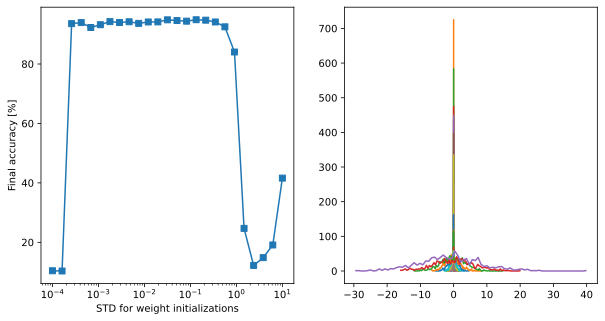

In [113]:
histograms = []
for h_idx in range(len(w_stds)):
  x, y = np.histogram(nets[h_idx].fc2.weight.data.flatten(), 80)

  histograms.append((x, y))

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(w_stds, accuracies, 's-')
plt.xscale('log')
plt.xlabel("STD for weight initializations")
plt.ylabel("Final accuracy [%]")

plt.subplot(122)
for h in histograms:
  plt.plot((h[1][1:]+h[1][:-1])/2,h[0], label='Baseline')
# plt.xlim(-1, 1)

plt.show()